# 🏔️ Step-back prompting with workflows for RAG with Argilla

This tutorial will show how to use step-back prompting with LlamaIndex workflows for RAG integrated with Argilla.

This prompting approach is based on "[Take a Step Back: Evoking Reasoning via Abstraction in Large Language Models](https://arxiv.org/abs/2310.06117)". This paper suggests that the response can be improved by asking the model to take a step back and reason about the context in a more abstract way. This way, the original query is abstracted and used to retrieved the relevant information. Then, this context along with the original context and query are used to generate the final response. 

[Argilla](https://github.com/argilla-io/argilla) is a collaboration tool for AI engineers and domain experts to build high-quality datasets. By doing this, you can analyze and enhance the quality of your data, leading to improved model performance by incorporating human feedback into the loop. The integration will automatically log the query, response, retrieved contexts with their scores, and the full trace (including spans and events), along with relevant metadata in Argilla. By default, you'll have the ability to rate responses, provide feedback, and evaluate the retrieved contexts, ensuring accuracy and preventing any discrepancies.

It includes the following steps:

- Setting up the Argilla handler for LlamaIndex.
- Designing the step-back workflow.
- Run the step-back workflow with LlamaIndex and automatically log the responses to Argilla.

## Getting started

### Deploy the Argilla server¶

If you already have deployed Argilla, you can skip this step. Otherwise, you can quickly deploy Argilla following [this guide](https://docs.argilla.io/latest/getting_started/quickstart/).


### Set up the environment¶

To complete this tutorial, you need to install this integration.

> Check the GitHub repository [here](https://github.com/argilla-io/argilla-llama-index).

In [ ]:
%pip install "argilla-llama-index>=2.1.0"

Let's make the required imports:


In [ ]:
from llama_index.core import (
    Settings,
    SimpleDirectoryReader,
    VectorStoreIndex,
)
from llama_index.core.instrumentation import get_dispatcher
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.response_synthesizers import ResponseMode
from llama_index.core.schema import NodeWithScore
from llama_index.core.workflow import (
    Context,
    StartEvent,
    StopEvent,
    Workflow,
    step,
)

from llama_index.core import get_response_synthesizer
from llama_index.core.workflow import Event
from llama_index.utils.workflow import draw_all_possible_flows
from llama_index.llms.openai import OpenAI

from argilla_llama_index import ArgillaHandler

We need to set the OpenAI API key. The OpenAI API key is required to run queries using GPT models.

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "sk-..."

## Set the Argilla's LlamaIndex handler

To easily log your data into Argilla within your LlamaIndex workflow, you only need to initialize the Argilla handler and attach it to the Llama Index dispatcher for spans and events. This ensures that the predictions obtained using LlamaIndex are automatically logged to the Argilla instance, along with the useful metadata.

- `dataset_name`: The name of the dataset. If the dataset does not exist, it will be created with the specified name. Otherwise, it will be updated.
- `api_url`: The URL to connect to the Argilla instance.
- `api_key`: The API key to authenticate with the Argilla instance.
- `number_of_retrievals`: The number of retrieved documents to be logged. Defaults to 0.
- `workspace_name`: The name of the workspace to log the data. By default, the first available workspace.

> For more information about the credentials, check the documentation for [users](https://docs.argilla.io/latest/how_to_guides/user/) and [workspaces](https://docs.argilla.io/latest/how_to_guides/workspace/).


In [ ]:
argilla_handler = ArgillaHandler(
    dataset_name="workflow_llama_index",
    api_url="http://localhost:6900",
    api_key="argilla.apikey",
    number_of_retrievals=2,
)
root_dispatcher = get_dispatcher()
root_dispatcher.add_span_handler(argilla_handler)
root_dispatcher.add_event_handler(argilla_handler)

## Define the step-back workflow

First, we need to define the two events that will be used in the step-back workflow. The `StepBackEvent` that will receive the step-back query, and the `RetriverEvent` that will receive the relevant nodes for the original and step-back queries after the retrieval.

In [ ]:
class StepBackEvent(Event):
    """Get the step-back query"""

    step_back_query: str


class RetrieverEvent(Event):
    """Result of running the retrievals"""

    nodes_original: list[NodeWithScore]
    nodes_step_back: list[NodeWithScore]

Next, we will define the prompts according to the original paper to get the step-back query and then get the final response.

In [ ]:
STEP_BACK_TEMPLATE = """
You are an expert at world knowledge. Your task is to step back and
paraphrase a question to a more generic step-back question, which is
easier to answer. Here are a few examples:

Original Question: Which position did Knox Cunningham hold from May 1955 to Apr 1956?
Stepback Question: Which positions have Knox Cunningham held in his career?

Original Question: Who was the spouse of Anna Karina from 1968 to 1974?
Stepback Question: Who were the spouses of Anna Karina?

Original Question: what is the biggest hotel in las vegas nv as of November 28, 1993
Stepback Question: what is the size of the hotels in las vegas nv as of November 28, 1993?

Original Question: {original_query}
Stepback Question:
"""

GENERATE_ANSWER_TEMPLATE = """
You are an expert of world knowledge. I am going to ask you a question.
Your response should be comprehensive and not contradicted with the
following context if they are relevant. Otherwise, ignore them if they are
not relevant.

{context_original}
{context_step_back}

Original Question: {query}
Answer:
"""

Now, we will define the step-back workflow. In this case, the workflow will be linear. First, we will prompt the LLM to make an abstraction of the original query (step-back prompting). Then, we will retrieve the relevant nodes for the original and step-back queries. Finally, we will prompt the LLM to generate the final response.

In [ ]:
class RAGWorkflow(Workflow):
    @step
    async def step_back(
        self, ctx: Context, ev: StartEvent
    ) -> StepBackEvent | None:
        """Generate the step-back query."""
        query = ev.get("query")
        index = ev.get("index")

        if not query:
            return None

        if not index:
            return None

        llm = Settings.llm
        step_back_query = llm.complete(
            prompt=STEP_BACK_TEMPLATE.format(original_query=query),
            formatted=True,
        )

        await ctx.set("query", query)
        await ctx.set("index", index)

        return StepBackEvent(step_back_query=str(step_back_query))

    @step
    async def retrieve(
        self, ctx: Context, ev: StepBackEvent
    ) -> RetrieverEvent | None:
        "Retrieve the relevant nodes for the original and step-back queries."
        query = await ctx.get("query", default=None)
        index = await ctx.get("index", default=None)

        await ctx.set("step_back_query", ev.step_back_query)

        retriever = index.as_retriever(similarity_top_k=2)
        nodes_step_back = await retriever.aretrieve(ev.step_back_query)
        nodes_original = await retriever.aretrieve(query)

        return RetrieverEvent(
            nodes_original=nodes_original, nodes_step_back=nodes_step_back
        )

    @step
    async def synthesize(self, ctx: Context, ev: RetrieverEvent) -> StopEvent:
        """Return a response using the contextualized prompt and retrieved nodes."""
        nodes_original = ev.nodes_original
        nodes_step_back = ev.nodes_step_back

        context_original = max(
            nodes_original, key=lambda node: node.get_score()
        ).get_text()
        context_step_back = max(
            nodes_step_back, key=lambda node: node.get_score()
        ).get_text()

        query = await ctx.get("query", default=None)
        formatted_query = GENERATE_ANSWER_TEMPLATE.format(
            context_original=context_original,
            context_step_back=context_step_back,
            query=query,
        )

        response_synthesizer = get_response_synthesizer(
            response_mode=ResponseMode.COMPACT
        )

        response = response_synthesizer.synthesize(
            formatted_query, nodes=ev.nodes_original
        )
        return StopEvent(result=response)

In [ ]:
draw_all_possible_flows(RAGWorkflow, filename="step_back_workflow.html")

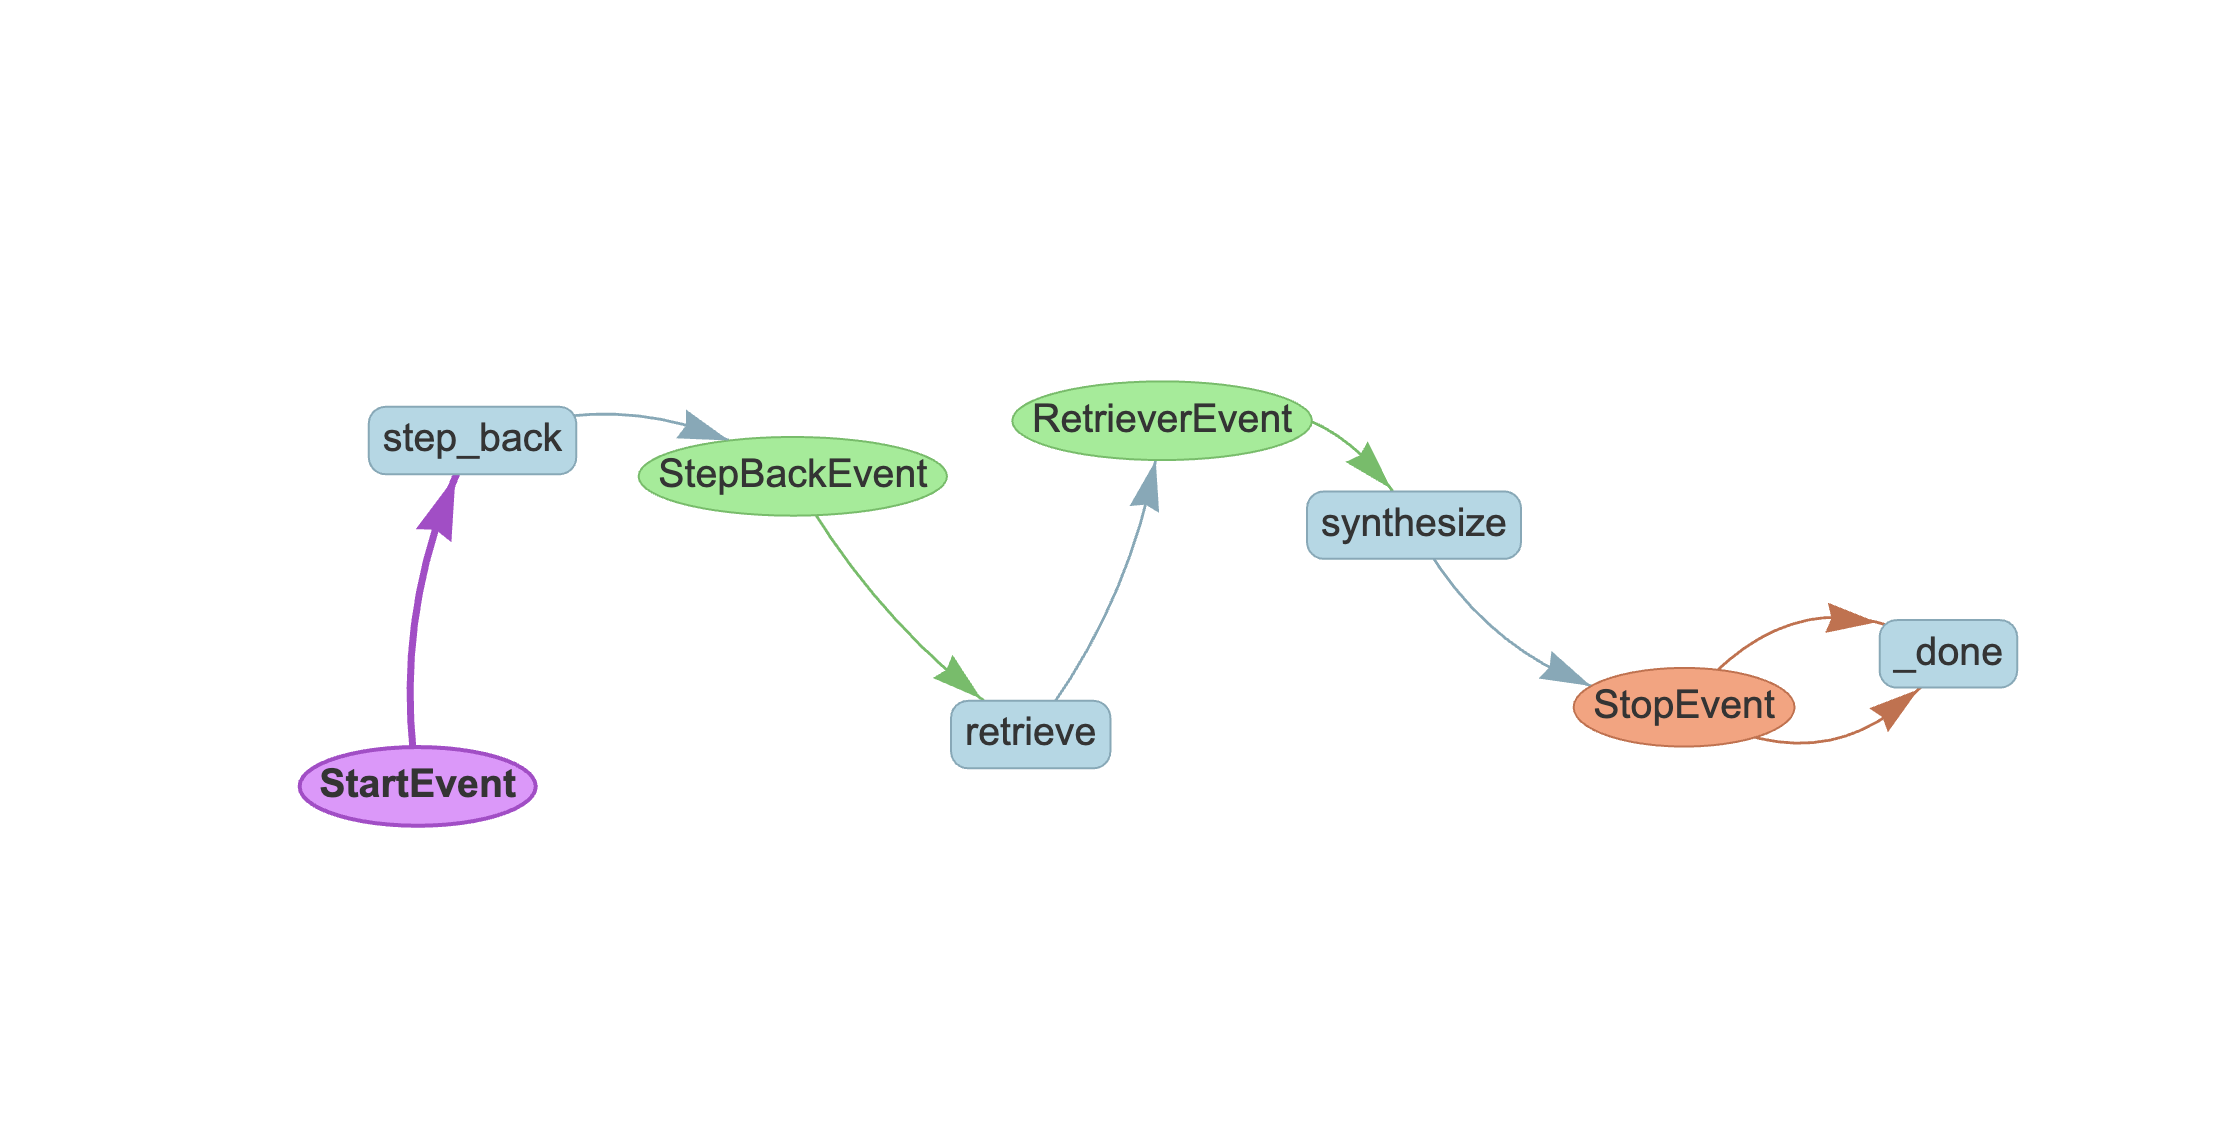

## Run the step-back workflow

We will use an example `.txt` file obtained from the [LlamaIndex documentation](https://docs.llamaindex.ai/en/stable/getting_started/starter_example.html). 

In [ ]:
# Retrieve the data if needed
!mkdir -p ../../data
!curl https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/paul_graham/paul_graham_essay.txt -o ../../data/paul_graham_essay.txt

Now, let's create a LlamaIndex index out of this document. As the highest-rated context for the original and step-back query will be included in the final prompt, we will lower the chuck size and use a `SentenceSplitter`

In [ ]:
# LLM settings
Settings.llm = OpenAI(model="gpt-3.5-turbo", temperature=0.8)

# Load the data and create the index
transformations = [
    SentenceSplitter(chunk_size=256, chunk_overlap=75),
]

documents = SimpleDirectoryReader("../../data").load_data()
index = VectorStoreIndex.from_documents(
    documents=documents,
    transformations=transformations,
)

Now, let's run the step-back workflow and make a query.

In [ ]:
w = RAGWorkflow()

result = await w.run(query="What's Paul's work", index=index)
result

The generated response will be automatically logged in our Argilla instance. Check it out! From Argilla, you can quickly look at your predictions and annotate them so you can combine both synthetic data and human feedback.

> You can check [this guide](https://docs.argilla.io/latest/how_to_guides/annotate/) to know how to annotate your data.

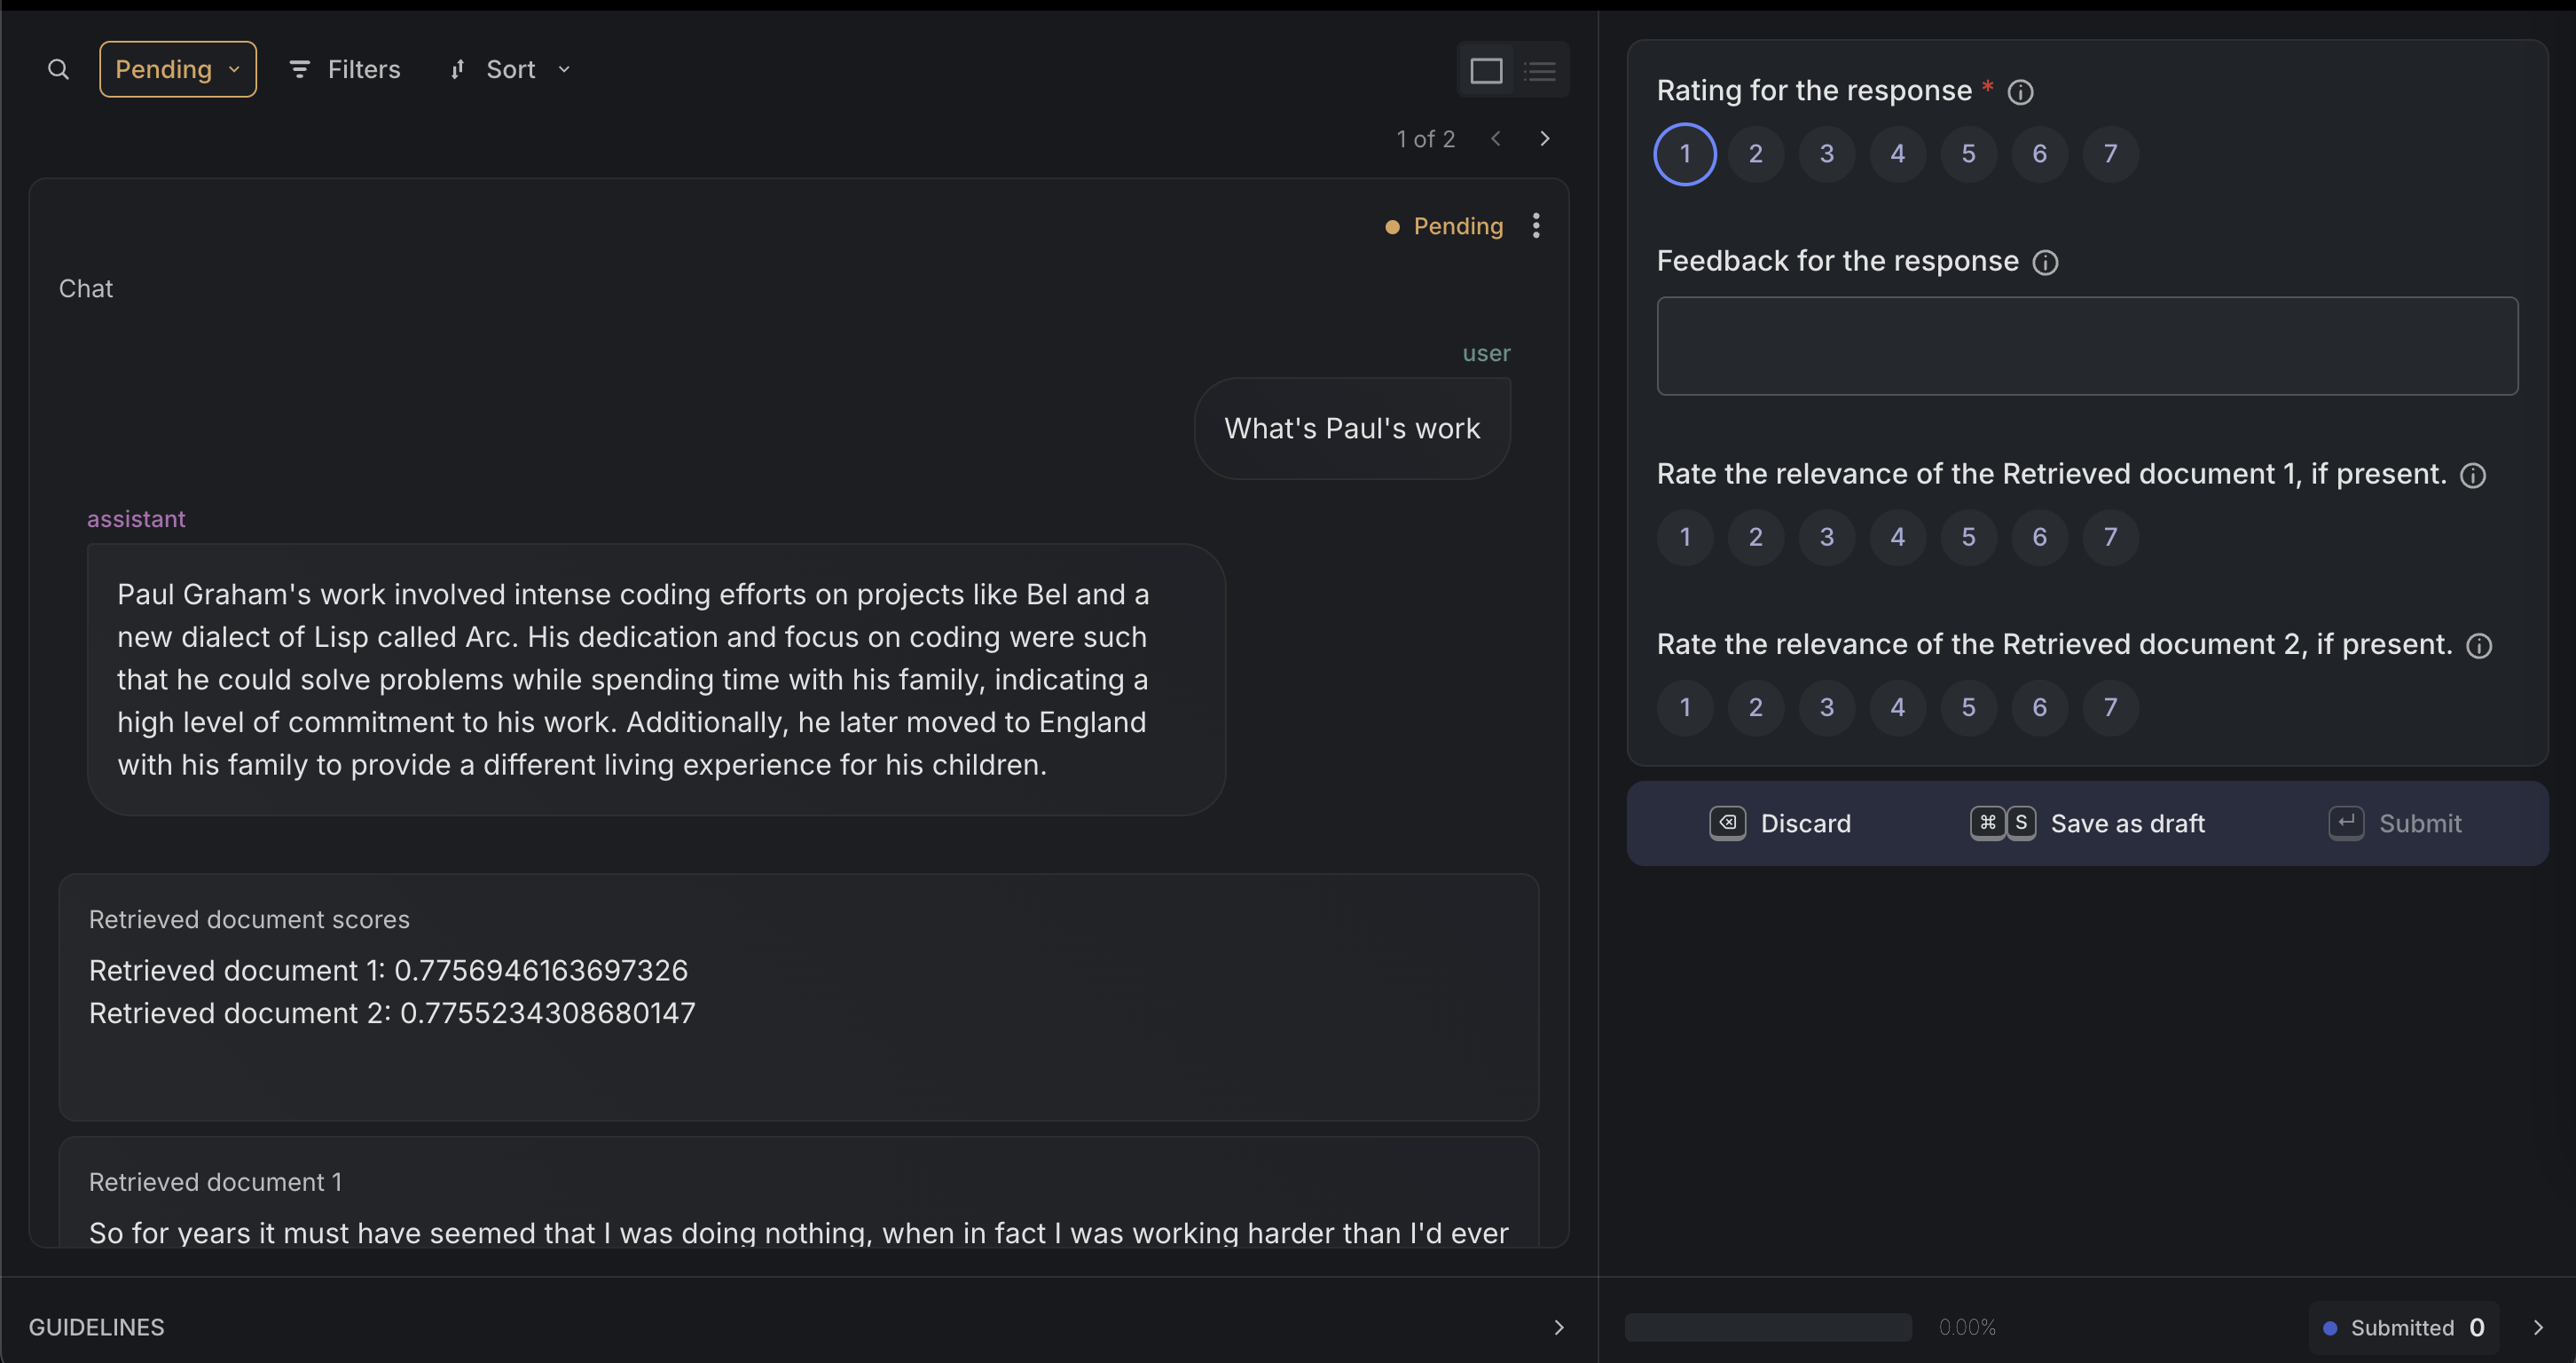

## Next steps

Once you've annotated your data, you can retrieve it from Argilla. By integrating human feedback into the process, we’ve guaranteed data quality, making it ready for fine-tuning your model. Moreover, to maintain model performance and prevent data drift, you can set aside a portion of the data for ongoing evaluation over time.